In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import torch
from torch import nn
from models.imavae import IMAVAE

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# 1. Generate Data without observed covariates

We construct the synthetic data for mediation analysis as below:
\begin{align*}
t &\sim \text{Bernoulli}(p) \\
\boldsymbol{z}_m &\sim \mathcal{N}(0, \sigma_m^2 \textbf{I}) + c_1 \mathbb{1}(t = 1) \\
\boldsymbol{m} &= f(\boldsymbol{z}_m) + c_2 \epsilon_{x} \\
y &= \alpha t + \boldsymbol{\beta}^{\text{T}} \boldsymbol{z}_m + \epsilon_{y}
\end{align*}
where $0 < p < 1$ and $c \in \mathbb{R}$ are constants, $f$ is a nonlinear function which is modeled by an **un-trained** multi-layer perceptron (MLP), $\alpha$ and $\beta$ are the coefficients which build a linear relationship between $\boldsymbol{z}$ and $t, \boldsymbol{y}$, and $\epsilon_{x}$ and $\epsilon_{y}$ are Gaussian noise terms.

In [2]:
N = 3000
p, c1, c2, sigma_m, noise_scale = 0.5, 4, 0.1, 1, 0.01
m_dim, z_m_dim, hidden_dim = 50, 10, 25
f = nn.Sequential(
    nn.Linear(z_m_dim, hidden_dim), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim, m_dim)
)

T = np.random.binomial(n=1, p=[p for _ in range(N)]).reshape(-1,1)
Z_m0 = np.random.multivariate_normal(mean=np.zeros(z_m_dim), cov=sigma_m*np.eye(z_m_dim), size=N)
Z_m1 = Z_m0 + c1
Z_m = np.array([Z_m0[i,:] if T[i][0] == 0 else Z_m1[i,:] for i in range(N)])
with torch.no_grad():
    M = f(torch.tensor(Z_m).float()).numpy()
    M += c2 * np.random.randn(M.shape[0],M.shape[1])
alpha = np.random.uniform(-2,2,size=1)
beta = np.random.uniform(-1,1,size=z_m_dim)
Y = (alpha * T.reshape(-1) + Z_m @ beta + noise_scale * np.random.normal(size=N)).reshape(-1,1)

The average causal mediation, direct, and total effect are defined as:
\begin{align}
\bar{\delta}(t) &= \mathbb{E}\left[ Y_i(t, M_i(1)) - Y_i(t, M_i(0)) \right] \\
\bar{\zeta}(t) &= \mathbb{E}\left[ Y_i(1, M_i(t)) - Y_i(0, M_i(t)) \right] \\
\bar{\tau} &= \mathbb{E}\left[ Y_i(1, M_i(1)) - Y_i(0, M_i(0)) \right]
\end{align}

In [3]:
Y0_M0 = (alpha * np.zeros(N) + Z_m0 @ beta + noise_scale * np.random.normal(size=N)).reshape(-1,1)
Y0_M1 = (alpha * np.zeros(N) + Z_m1 @ beta + noise_scale * np.random.normal(size=N)).reshape(-1,1)
Y1_M0 = (alpha * np.ones(N) + Z_m0 @ beta + noise_scale * np.random.normal(size=N)).reshape(-1,1)
Y1_M1 = (alpha * np.ones(N) + Z_m1 @ beta + noise_scale * np.random.normal(size=N)).reshape(-1,1)
acme_c = (Y0_M1 - Y0_M0).mean()
acme_t = (Y1_M1 - Y1_M0).mean()
ade_c = (Y1_M0 - Y0_M0).mean()
ade_t = (Y1_M1 - Y0_M1).mean()
ate = (Y1_M1 - Y0_M0).mean()
print("True ACME (control) = {:.4f}".format(acme_c))
print("True ACME (treatment) = {:.4f}".format(acme_t))
print("True ADE (control) = {:.4f}".format(ade_c))
print("True ADE (treatment) = {:.4f}".format(ade_t))
print("True ATE = {:.4f}".format(ate))

True ACME (control) = 4.7044
True ACME (treatment) = 4.7042
True ADE (control) = -0.7401
True ADE (treatment) = -0.7403
True ATE = 3.9641


# 2. Fit IMAVAE model and evaluate mediation effect

In [4]:
imavae = IMAVAE(n_components=10, n_sup_networks=10, n_hidden_layers=1, hidden_dim=25, 
               optim_name='AdamW', weight_decay=0.0, recon_weight=1.0, elbo_weight=1.0)
_ = imavae.fit(
    M, T, Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=True
)
acme_c_mean, acme_c_std = imavae.acme_score(T, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(T, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(T, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(T, treatment=True)
ate_mean, ate_std = imavae.ate_score(T)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))

Beginning Training


Epoch: 199, Current Training MSE: 0.0148278, Current Pred Metric: [1.1393352, 1.


Saving the last epoch with training MSE: 0.0148278 and Pred Metric: [1.1393352, 1.1393352, 1.1393352, 1.1393352, 1.1393352, 1.1393352, 1.1393352, 1.1393352, 1.1393352, 1.1393352]
ACME (control) = 4.5956 +/- 0.0256
ACME (treatment) = 4.6008 +/- 0.0331
ADE (control) = -0.4699 +/- 0.0000
ADE (treatment) = -0.4699 +/- 0.0000
ATE = 4.1308 +/- 0.0272


### 2.1 Does the latent feature learned by IMAVAE recover the true mediator?

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Text(0.5, 1.0, 'Mediator estimated by IMAVAE')

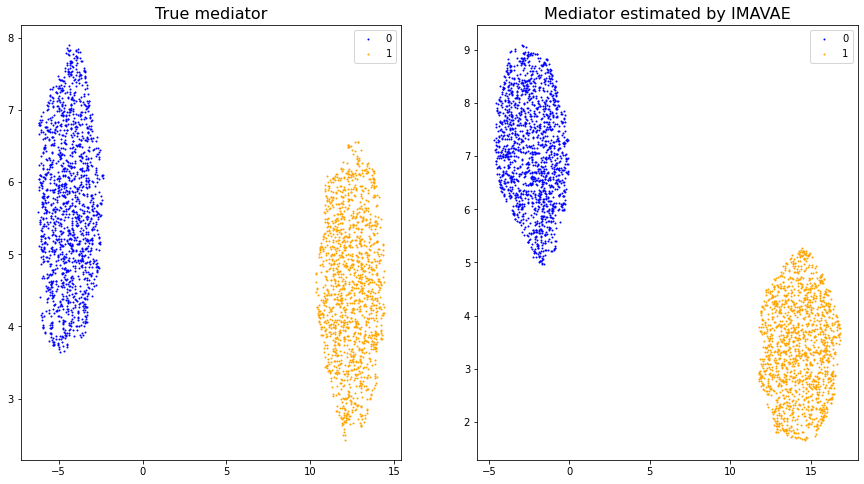

In [5]:
reducer_true, reducer_imavae = umap.UMAP(), umap.UMAP()
embedding_true = reducer_true.fit_transform(Z_m)
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])
embedding_imavae = reducer_imavae.fit_transform(np.array(z_m))

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,8))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(embedding_true[i,0], embedding_true[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(embedding_imavae[i,0], embedding_imavae[i,1], c=c_dict[g], label=g, s=1)
axs[0].legend()
axs[0].set_title("True mediator", size=16)
axs[1].legend()
axs[1].set_title("Mediator estimated by IMAVAE", size=16)

# 3. Generate Data with observed covariates

By including observed covariates $\boldsymbol{x}$, we construct the dataset as follows:
\begin{align*}
\boldsymbol{x} &\sim \mathcal{N}(\boldsymbol{0}, \sigma_x^2 \textbf{I}) \\
t &\sim \text{Bernoulli}(\text{sigmoid}(\boldsymbol{w}_t^{\text{T}} \boldsymbol{x})) \\
\boldsymbol{z}_m &\sim \mathcal{N}(0, \sigma_m^2 \textbf{I}) + c_1 \mathbb{1}(t = 1) + c_2 g(\boldsymbol{x}) \\
\boldsymbol{m} &= f(\boldsymbol{z}_m) + c_3 \epsilon_{x} \\
y &= \alpha t + \boldsymbol{\beta}^{\text{T}} \boldsymbol{z}_m + \boldsymbol{\gamma}^{\text{T}} \boldsymbol{x} + \epsilon_{y}
\end{align*}
where $c_1, c_2, c_3, \alpha \in \mathbb{R}$ are constants, $\boldsymbol{w}_t, \boldsymbol{\beta}, \boldsymbol{\gamma}$ are coefficient vectors, and $f$ and $g$ are nonlinear functions which are modeled by **un-trained** multi-layer perceptrons (MLPs). $\epsilon_{x}$ and $\epsilon_{y}$ are Gaussian noise terms.

In [6]:
N = 3000
c1, c2, c3, sigma_x, sigma_m, noise_scale = 4, 0.1, 0.1, 0.5, 1, 0.01
m_dim, z_m_dim, x_dim, hidden_dim = 50, 10, 20, 25
f = nn.Sequential(
    nn.Linear(z_m_dim, hidden_dim), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim, m_dim)
)
g = nn.Sequential(
    nn.Linear(x_dim, hidden_dim), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim, z_m_dim)
)

w_t = beta = np.random.uniform(-1,1,size=x_dim)
X = np.random.multivariate_normal(mean=np.zeros(x_dim), cov=sigma_x*np.eye(x_dim), size=N)
logit = X @ w_t
T = np.random.binomial(n=1, p=[1/(1 + np.exp(-s)) for s in logit]).reshape(-1,1)
with torch.no_grad():
    gx = g(torch.tensor(X).float()).numpy()
Z_m0 = np.random.multivariate_normal(mean=np.zeros(z_m_dim), cov=sigma_m*np.eye(z_m_dim), size=N) + c2 * gx
Z_m1 = Z_m0 + c1
Z_m = np.array([Z_m0[i,:] if T[i][0] == 0 else Z_m1[i,:] for i in range(N)])
with torch.no_grad():
    M = f(torch.tensor(Z_m).float()).numpy()
    M += c3 * np.random.randn(M.shape[0],M.shape[1])
alpha = np.random.uniform(-2,2,size=1)
beta = np.random.uniform(-1,1,size=z_m_dim)
gamma = np.random.uniform(-0.5,0.5,size=x_dim)
Y = (alpha * T.reshape(-1) + Z_m @ beta + X @ gamma + noise_scale * np.random.normal(size=N)).reshape(-1,1)

In [7]:
Y0_M0 = (alpha * np.zeros(N) + Z_m0 @ beta + X @ gamma + noise_scale * np.random.normal(size=N)).reshape(-1,1)
Y0_M1 = (alpha * np.zeros(N) + Z_m1 @ beta + X @ gamma + noise_scale * np.random.normal(size=N)).reshape(-1,1)
Y1_M0 = (alpha * np.ones(N) + Z_m0 @ beta + X @ gamma + noise_scale * np.random.normal(size=N)).reshape(-1,1)
Y1_M1 = (alpha * np.ones(N) + Z_m1 @ beta + X @ gamma + noise_scale * np.random.normal(size=N)).reshape(-1,1)
acme_c = (Y0_M1 - Y0_M0).mean()
acme_t = (Y1_M1 - Y1_M0).mean()
ade_c = (Y1_M0 - Y0_M0).mean()
ade_t = (Y1_M1 - Y0_M1).mean()
ate = (Y1_M1 - Y0_M0).mean()
print("True ACME (control) = {:.4f}".format(acme_c))
print("True ACME (treatment) = {:.4f}".format(acme_t))
print("True ADE (control) = {:.4f}".format(ade_c))
print("True ADE (treatment) = {:.4f}".format(ade_t))
print("True ATE = {:.4f}".format(ate))

True ACME (control) = 14.9964
True ACME (treatment) = 14.9963
True ADE (control) = 1.2341
True ADE (treatment) = 1.2340
True ATE = 16.2304


# 4. Fit IMAVAE on the new dataset and evaluate mediation effect

In [8]:
imavae = IMAVAE(n_components=10, n_sup_networks=10, n_hidden_layers=1, hidden_dim=25, 
               optim_name='AdamW', weight_decay=0.0, recon_weight=1.0, elbo_weight=1.0)
XT = np.concatenate([T,X], axis=1)
_ = imavae.fit(
    M, XT, Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=True
)
acme_c_mean, acme_c_std = imavae.acme_score(XT, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(XT, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(XT, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(XT, treatment=True)
ate_mean, ate_std = imavae.ate_score(XT)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))

Beginning Training


Epoch: 199, Current Training MSE: 0.0141188, Current Pred Metric: [0.5617891, 0.


Saving the last epoch with training MSE: 0.0141188 and Pred Metric: [0.5617891, 0.5617891, 0.5617891, 0.5617891, 0.5617891, 0.5617891, 0.5617891, 0.5617891, 0.5617891, 0.5617891]
ACME (control) = 13.3696 +/- 0.0423
ACME (treatment) = 13.3806 +/- 0.0422
ADE (control) = -1.1382 +/- 0.0000
ADE (treatment) = -1.1382 +/- 0.0000
ATE = 12.2421 +/- 0.0476


### 4.1 Does the latent feature learned by IMAVAE recover the true mediator?

Text(0.5, 1.0, 'Mediator estimated by IMAVAE')

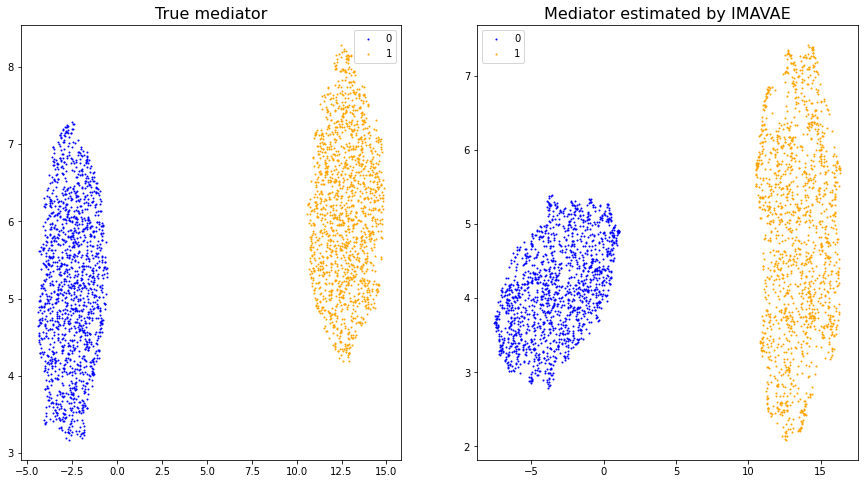

In [9]:
reducer_true, reducer_imavae = umap.UMAP(), umap.UMAP()
embedding_true = reducer_true.fit_transform(Z_m)
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    t0, t1 = torch.cat([t0, torch.tensor(X).float()], dim=1), torch.cat([t1, torch.tensor(X).float()], dim=1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])
embedding_imavae = reducer_imavae.fit_transform(np.array(z_m))

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,8))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(embedding_true[i,0], embedding_true[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(embedding_imavae[i,0], embedding_imavae[i,1], c=c_dict[g], label=g, s=1)
axs[0].legend()
axs[0].set_title("True mediator", size=16)
axs[1].legend()
axs[1].set_title("Mediator estimated by IMAVAE", size=16)